In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load OpenPose Data

In [2]:
keypoints = np.load("{}/data/all_keypoints.npy".format(homedir), allow_pickle=True)
keypoints[0]

array(['ESzlIzyO',
       array([[3.32047e+02, 3.98396e+02, 8.52781e-01, ..., 3.91341e+02,
        1.03356e+03, 8.47541e-01],
       [3.32040e+02, 3.98392e+02, 8.51686e-01, ..., 3.91345e+02,
        1.03357e+03, 8.46827e-01],
       [3.32055e+02, 3.98462e+02, 8.60609e-01, ..., 3.91352e+02,
        1.03357e+03, 8.41133e-01],
       ...,
       [3.21681e+02, 4.05430e+02, 9.21052e-01, ..., 3.98331e+02,
        1.03712e+03, 8.62005e-01],
       [3.21715e+02, 4.05454e+02, 9.22338e-01, ..., 3.98333e+02,
        1.03704e+03, 8.61394e-01],
       [3.28646e+02, 3.98296e+02, 8.48421e-01, ..., 3.87965e+02,
        1.03360e+03, 8.37185e-01]])], dtype=object)

In [3]:
features_kp = np.zeros((383, 60*75 + 1), dtype=object)

In [4]:
# downsample the keypoints 
# each video has framerate = 30; take frames 30-89 to represent the second 2 seconds of each video
for i, subject in enumerate(keypoints): 
    subjectId = subject[0]
    kp = subject[1]
    
    features_kp[i, 0] = subjectId
    features_kp[i, 1:] = kp[30:90].flatten()

In [5]:
df_kp = pd.DataFrame(features_kp)
df_kp = df_kp.rename(columns={0: 'subjectid'})
df_kp

,subjectid,1,2,3,4,5,6,7,8,9,...,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500
0,ESzlIzyO,335.63,405.249,0.895572,290.132,503.095,0.849572,262.146,513.397,0.86198,...,0.376569,509.991,1058.1,0.757028,485.627,1071.88,0.835966,401.921,1030.12,0.89212
1,zN0O4jLu,230.898,248.255,0.856856,318.156,353.015,0.853513,258.749,353.053,0.774952,...,0.668692,206.277,1155.67,0.775272,206.374,1138.38,0.647594,321.438,1113.89,0.63126
2,nM7tQcBS,436.93,84.2963,0.849167,381.013,182.025,0.892465,318.176,168.019,0.817223,...,0.805224,373.935,1030.18,0.754506,339.108,1026.63,0.706043,300.716,988.272,0.812182
3,OuYG4U64,541.525,321.646,0.933987,461.399,457.626,0.900076,408.853,454.199,0.844952,...,0.879541,440.289,1075.43,0.846009,408.952,1075.43,0.874136,363.458,1023.09,0.787195
4,tFSyXitq,607.894,267.412,0.94842,524.122,440.729,0.888483,388.191,440.546,0.783813,...,0.651009,524.325,1833.72,0.543139,471.893,1839,0.54514,419.543,1750.08,0.608088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,bqTsXpKl,276.187,471.733,0.84257,332.062,548.464,0.86469,272.7,548.481,0.871379,...,0.717557,206.472,1047.57,0.862025,206.464,1037.14,0.770676,297.223,1005.69,0.775751
379,UDXlpEgF,468.19,94.8551,0.782617,426.347,230.757,0.822717,373.862,206.547,0.822391,...,0.830474,387.972,908.085,0.88934,366.96,908.177,0.866333,332.044,876.437,0.79478
380,b632WDpF,644.923,141.884,0.908126,560.965,382.903,0.869544,429.859,382.861,0.741821,...,0.799335,602.817,1718.56,0.735241,560.778,1718.44,0.740828,492.83,1650.39,0.68736
381,ybGzWMPA,398.35,206.403,0.923946,352.968,297.207,0.897122,293.692,290.32,0.907,...,0.846899,349.699,918.397,0.831726,328.545,925.398,0.806425,293.832,904.335,0.782418


### Load Precalculated Features

In [6]:
# Create a numpy array containing all the calculated features from the original paper
# Exclude fields 0 (identifiers), 2 (orientation), 3 (framerate) and 537+ (survey data)
df_calc = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/dataClean_text.csv')
df_calc = df_calc.iloc[:,:537]
df_calc.drop(['X', 'orientation', 'framerate'], axis=1, inplace=True)
df_calc

,subjectid,n,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,...,neck_max_y_acc_stand2sit,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand
0,kGhQ1FQc,5,18.752067,-0.275275,0.27,0.631539,0.058177,5,5.972633,-1.618283,...,3.505124,1.081186,1.006474,1.221493,0.869235,0.974188,104.281728,130.765245,174.111505,170.157767
1,KyINSk8e,5,13.346667,-0.216883,0.37,0.395926,0.071269,5,4.337667,-1.101100,...,3.654509,1.057510,1.018101,0.979709,0.735422,0.949425,113.416249,122.046417,183.473800,170.403354
2,ybGzWMPA,5,9.175833,0.108442,0.54,0.152175,0.044839,5,4.304300,0.008342,...,4.730823,1.324459,1.407150,1.272274,1.064869,0.963154,110.360354,116.014708,154.888698,154.736858
3,b632WDpF,4,11.033333,0.133333,0.36,0.234965,0.031573,4,3.833333,-0.700000,...,3.772340,1.523048,1.506615,1.525126,1.145206,0.948291,359.999821,132.874089,179.434883,172.483812
4,UDXlpEgF,5,11.444767,-0.108442,0.44,0.225910,0.045701,5,4.471133,-0.600600,...,5.261429,1.017858,0.947927,0.879847,0.623896,0.993858,113.339615,115.098166,178.141457,171.161810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,tFSyXitq,5,10.066667,0.225000,0.50,0.344867,0.069775,5,4.800000,0.075000,...,4.927668,0.864066,0.852848,1.118739,0.830468,0.966577,94.484956,115.572113,176.582448,175.372981
401,OuYG4U64,5,10.477133,0.116783,0.48,0.178317,0.044853,5,4.771433,-0.150150,...,4.448819,1.151292,1.100129,1.012293,0.837304,0.965469,109.993607,106.238842,182.016620,166.714119
402,nM7tQcBS,5,5.366667,0.058333,0.93,0.082731,0.076364,5,2.633333,0.008333,...,6.866623,1.374656,1.467833,1.375480,1.147340,0.970511,92.538523,108.185109,167.608827,164.889848
403,zN0O4jLu,5,24.290933,0.075075,0.21,0.377854,0.016347,5,12.412400,0.241908,...,2.242874,0.871977,1.034409,0.565355,0.657769,0.962403,106.005854,96.882321,160.433369,152.676643


### Load Survey Data (labels)

In [7]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [8]:
# join the dataframes by subjectId 
df_join = df_kp.set_index('subjectid').join(df_calc.set_index('subjectid'))
df_join = df_join.join(df_survey.set_index('subjectid')).astype('float32')
df_join

,1,2,3,4,5,6,7,8,9,10,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
ESzlIzyO,335.630005,405.248993,0.895572,290.131989,503.095001,0.849572,262.145996,513.396973,0.861980,346.191986,...,0.831638,1.153598,0.657760,0.648148,0.962856,97.261581,99.249542,185.223724,181.791748,0.0
zN0O4jLu,230.897995,248.255005,0.856856,318.156006,353.015015,0.853513,258.748993,353.053009,0.774952,178.574997,...,0.871977,1.034409,0.565355,0.657769,0.962403,106.005852,96.882324,160.433365,152.676636,0.0
nM7tQcBS,436.929993,84.296303,0.849167,381.013000,182.024994,0.892465,318.175995,168.018997,0.817223,426.196991,...,1.374656,1.467833,1.375480,1.147340,0.970511,92.538521,108.185112,167.608826,164.889847,0.0
OuYG4U64,541.525024,321.645996,0.933987,461.398987,457.626007,0.900076,408.852997,454.199005,0.844952,440.260986,...,1.151292,1.100129,1.012293,0.837304,0.965469,109.993607,106.238846,182.016617,166.714127,0.0
tFSyXitq,607.893982,267.411987,0.948420,524.122009,440.729004,0.888483,388.191010,440.545990,0.783813,524.356995,...,0.864066,0.852848,1.118739,0.830468,0.966577,94.484955,115.572113,176.582443,175.372986,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bqTsXpKl,276.187012,471.733002,0.842570,332.062012,548.463989,0.864690,272.700012,548.481018,0.871379,248.317001,...,1.430404,1.485496,1.395664,1.191145,0.943775,100.105484,120.529755,174.666214,174.914749,0.0
UDXlpEgF,468.190002,94.855103,0.782617,426.346985,230.757004,0.822717,373.862000,206.546997,0.822391,370.494995,...,1.017858,0.947927,0.879847,0.623896,0.993858,113.339615,115.098167,178.141464,171.161804,0.0
b632WDpF,644.922974,141.884003,0.908126,560.965027,382.903015,0.869544,429.859009,382.860992,0.741821,555.565002,...,1.523048,1.506615,1.525126,1.145206,0.948291,359.999817,132.874084,179.434875,172.483810,0.0


#### Data validation 

In [27]:
# 383 examples // 80/10/10 split // 307/38/38 
NUM_TRAIN = 307
NUM_VAL = 38

train_data = df_join.iloc[:NUM_TRAIN]
val_data = df_join.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VAL]
test_data = df_join.iloc[NUM_TRAIN+NUM_VAL:]

In [32]:
# Check for number of OA positive and number of samples in the dataset
# Total
print(df_join.iloc[:,-1].count())  # 383
print(df_join.iloc[:,-1].sum())    # 24
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Test set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data.iloc[:,-1].count())  # 307
print(train_data.iloc[:,-1].sum())    # 17

# Validation set - This implies that if the model always predicts 0, it would have 89% val accuracy
print(val_data.iloc[:,-1].count())  # 38
print(val_data.iloc[:,-1].sum())    # 4

383
24.0
307
17.0
38
4.0


#### Create dataset

In [12]:
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

# reference: https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/4
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.dataframe = dataframe
        self.transform = transform

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[:-1]
        label = row[-1]
        
        # reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
        if self.transform:
            features = self.transform(features)
            
        return features, label

    def __len__(self):
        return len(self.dataframe)

#### Normalization

In [13]:
# compute mean and std of the features 
means = []
stds = []
for column in df_join.iloc[:,:-1]: # exclude last column, which has labels
    column_np = df_join[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [33]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [34]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 5033]) torch.Size([64])
tensor([[ 3.3720e-01, -4.8678e-01,  3.0878e-01,  ..., -1.7870e-01,
          1.6737e-01,  6.0435e-01],
        [-8.8118e-01, -1.4567e+00, -4.2296e-01,  ...,  6.9726e+00,
         -9.7447e-01, -8.3164e-01],
        [-2.1466e-01, -1.0127e+00,  7.3762e-01,  ...,  2.1319e-02,
         -1.7547e-01, -4.2994e-01],
        ...,
        [-1.1386e+00, -7.3378e-01, -4.4577e-01,  ..., -6.8745e-01,
          9.0467e-01, -2.2038e-01],
        [-8.0008e-01, -1.2946e+00,  3.0017e-03,  ...,  1.6758e-01,
          6.0822e-01, -7.7908e-02],
        [-8.9650e-02,  7.7694e-01,  1.1112e-01,  ..., -8.6222e-01,
         -1.2088e-01,  2.1189e-01]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])


#### Create a manually curated data set

In [35]:
df_join["time_sit2stand"]
potential_cols = df_join.filter(regex=(".*(time|speed|trunk).*")).columns.values
# for p in potential_cols:
#     print(p)
cols_manual = ['time_sit2stand',
'speed_sit2stand',
'time_sd_sit2stand',
'speed_sd_sit2stand',
'time_stand2sit',
'speed_stand2sit',
'time_sd_stand2sit',
'speed_sd_stand2sit',
'trunk_lean_range_mean',
'trunk_lean_sd',
'trunk_lean_max',
'trunk_lean_min',
'trunk_lean_ang_vel',
'trunk_lean_ang_acc',
'trunk_lean_max_ang_vel',
'trunk_lean_max_ang_acc',
'trunk_lean_min_ang_vel',
'trunk_lean_min_ang_acc',
'trunk_lean_range_mean_sit2stand',
'trunk_lean_sd_sit2stand',
'trunk_lean_max_sit2stand',
'trunk_lean_min_sit2stand',
'trunk_lean_ang_vel_sit2stand',
'trunk_lean_ang_acc_sit2stand',
'trunk_lean_max_ang_vel_sit2stand',
'trunk_lean_max_ang_acc_sit2stand',
'trunk_lean_min_ang_vel_sit2stand',
'trunk_lean_min_ang_acc_sit2stand',
'trunk_lean_range_mean_stand2sit',
'trunk_lean_sd_stand2sit',
'trunk_lean_max_stand2sit',
'trunk_lean_min_stand2sit',
'trunk_lean_ang_vel_stand2sit',
'trunk_lean_ang_acc_stand2sit',
'trunk_lean_max_ang_vel_stand2sit',
'trunk_lean_max_ang_acc_stand2sit',
'trunk_lean_min_ang_vel_stand2sit',
'trunk_lean_min_ang_acc_stand2sit',
'OA_check']
df_manual = df_join.loc[:,cols_manual]

In [36]:
# Create separate loader with manually selected columns

train_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

#### Create dataloaders with upsampling 

In [37]:
# Reference: https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):
        idxs = batch[0][:, 0].tolist()
        #classes = batch[0][:, 1]
        classes = batch[1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(figsize=(2, 15), dpi=72)

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(range(len(dl)))
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        num_images_seen = len(idxs_seen)

        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

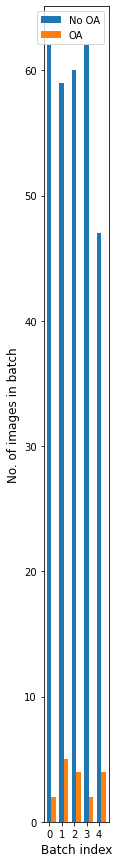

Avg Proportion of No OA per batch: 5.8
Avg Proportion of OA per batch: 0.34
Num. unique images seen: 306/307


In [39]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

<ipython-input-40-8623099a84a5>:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  class_weights_all = class_weights[labels]


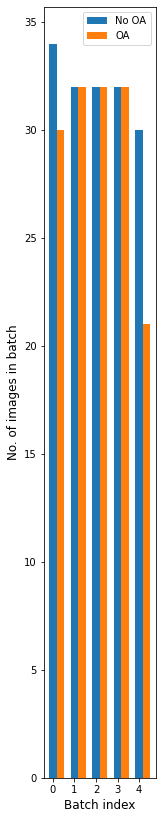

Avg Proportion of No OA per batch: 3.2
Avg Proportion of OA per batch: 2.9400000000000004
Num. unique images seen: 146/307


In [40]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

In [21]:
class Barebones_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores
    
def compare_scores_y(scores, y, num_correct, num_samples, num_positives):
    # Accumulates number of correct predictions, numer of samples and number of samples with prediction = 1
    preds = (scores > 0.5).float()
    num_correct += (preds == y).sum()
    num_samples += preds.size(0)
    num_positives += (preds == 1).sum()    
    return num_correct, num_samples, num_positives
    
def train_model(model, optimizer, loader_t, loader_v, epochs=1):
    model = model.to(device=device) 
    
    loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    train_pos_epoch = []
    val_pos_epoch = []
    
    BCEwithLogitLoss = nn.BCEWithLogitsLoss()
    
    for e in range(epochs):
        num_correct = 0
        num_samples = 0
        num_positives = 0

        for t, (x, y) in enumerate(loader_t):  
            model.train() 
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=dtype)

            scores = model(x).squeeze(1)
            loss = BCEwithLogitLoss(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_correct, num_samples, num_positives = \
            compare_scores_y(scores, y, num_correct, num_samples, num_positives)

        loss_epoch.append(loss.item())

        train_percent_pos = float(num_positives) / num_samples
        train_pos_epoch.append(100 * train_percent_pos)
        train_acc = float(num_correct) / num_samples
        train_acc_epoch.append(100 * train_acc)

        val_acc, val_percent_pos = check_accuracy(loader_v, model)
        val_acc_epoch.append(val_acc * 100)
        val_pos_epoch.append(val_percent_pos * 100)

        print('Epoch %d, loss = %.4f, train_acc = %.4f, val_acc = %.4f, train_pos = %.4f, val_pos = %.4f' % \
          (e, loss_epoch[-1], train_acc_epoch[-1], val_acc_epoch[-1], train_pos_epoch[-1], val_pos_epoch[-1]))

    return loss_epoch, train_acc_epoch, val_acc_epoch, train_pos_epoch, val_pos_epoch

def check_accuracy(loader, model):  
    num_correct = 0
    num_samples = 0
    num_positives = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            scores = model(x).squeeze(1)
            num_correct, num_samples, num_positives = \
                compare_scores_y(scores, y, num_correct, num_samples, num_positives)
        acc = float(num_correct) / num_samples
        percent_pos = float(num_positives) / num_samples
    return acc, percent_pos

#### Train model with normalized inputs, no oversampling

In [23]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.3716, train_acc = 93.8111, val_acc = 86.8421, train_pos = 0.6515, val_pos = 2.6316
Epoch 1, loss = 0.2230, train_acc = 95.1140, val_acc = 84.2105, train_pos = 0.6515, val_pos = 5.2632
Epoch 2, loss = 0.1127, train_acc = 94.7883, val_acc = 84.2105, train_pos = 1.6287, val_pos = 5.2632
Epoch 3, loss = 0.0900, train_acc = 96.0912, val_acc = 84.2105, train_pos = 1.6287, val_pos = 5.2632
Epoch 4, loss = 0.0568, train_acc = 97.3941, val_acc = 84.2105, train_pos = 2.9316, val_pos = 5.2632
Epoch 5, loss = 0.0404, train_acc = 98.3713, val_acc = 84.2105, train_pos = 3.9088, val_pos = 5.2632
Epoch 6, loss = 0.0298, train_acc = 98.3713, val_acc = 86.8421, train_pos = 3.9088, val_pos = 2.6316
Epoch 7, loss = 0.0316, train_acc = 100.0000, val_acc = 86.8421, train_pos = 5.5375, val_pos = 2.6316
Epoch 8, loss = 0.0105, train_acc = 99.0228, val_acc = 89.4737, train_pos = 4.5603, val_pos = 0.0000
Epoch 9, loss = 0.0132, train_acc = 100.0000, val_acc = 89.4737, train_pos = 5.5375, val_p

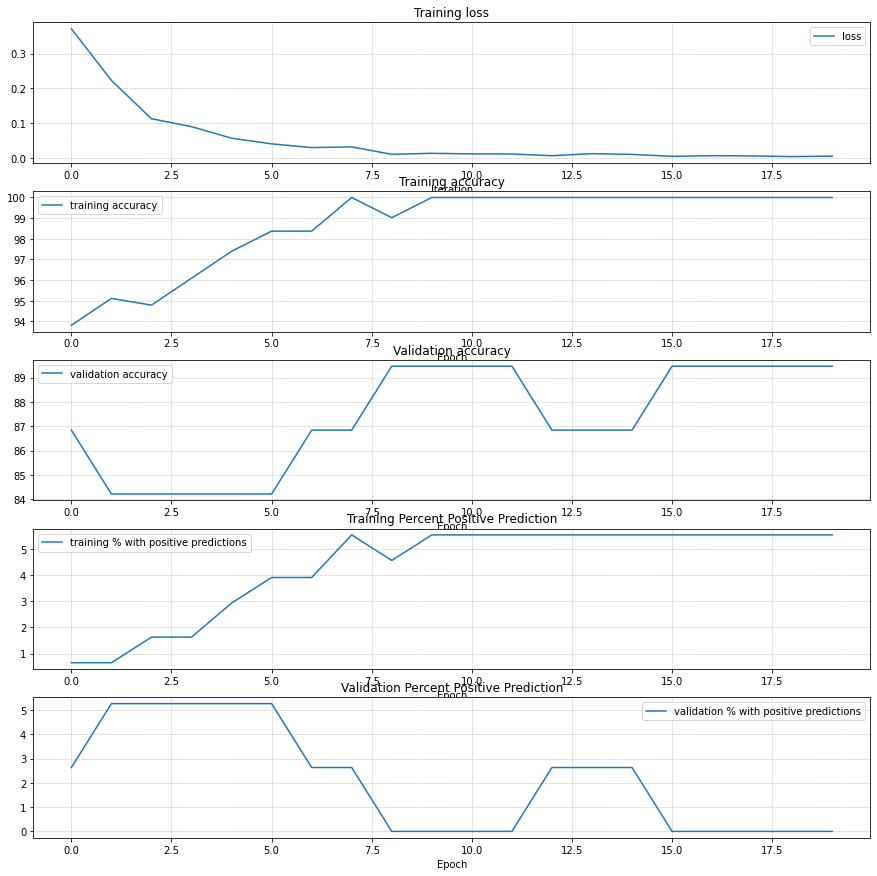

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [25]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.4235, train_acc = 65.4723, val_acc = 73.6842, train_pos = 39.4137, val_pos = 15.7895
Epoch 1, loss = 0.2927, train_acc = 83.7134, val_acc = 78.9474, train_pos = 36.4821, val_pos = 15.7895
Epoch 2, loss = 0.3268, train_acc = 87.6221, val_acc = 89.4737, train_pos = 56.6775, val_pos = 5.2632
Epoch 3, loss = 0.1067, train_acc = 91.8567, val_acc = 78.9474, train_pos = 40.7166, val_pos = 15.7895
Epoch 4, loss = 0.1501, train_acc = 97.0684, val_acc = 86.8421, train_pos = 51.1401, val_pos = 7.8947
Epoch 5, loss = 0.0637, train_acc = 98.3713, val_acc = 84.2105, train_pos = 53.4202, val_pos = 10.5263
Epoch 6, loss = 0.2013, train_acc = 96.4169, val_acc = 84.2105, train_pos = 49.8371, val_pos = 10.5263
Epoch 7, loss = 0.0326, train_acc = 99.6743, val_acc = 84.2105, train_pos = 41.3681, val_pos = 5.2632
Epoch 8, loss = 0.0189, train_acc = 99.6743, val_acc = 84.2105, train_pos = 49.1857, val_pos = 5.2632
Epoch 9, loss = 0.0183, train_acc = 99.6743, val_acc = 84.2105, train_pos = 4

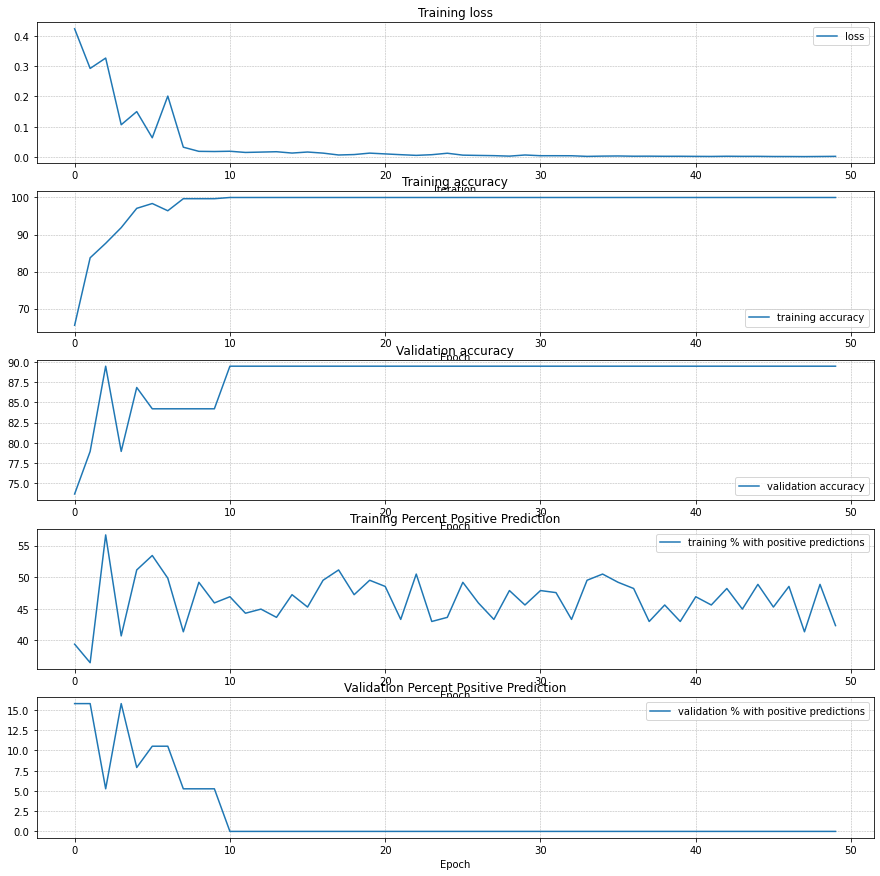

In [26]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [41]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [42]:
input_size = 5033
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 157.5431, train_acc = 77.8502, val_acc = 89.4737, train_pos = 16.6124, val_pos = 0.0000
Epoch 1, loss = 275.8387, train_acc = 94.4625, val_acc = 89.4737, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 136.3171, train_acc = 94.4625, val_acc = 89.4737, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = 44.4666, train_acc = 94.1368, val_acc = 86.8421, train_pos = 0.3257, val_pos = 2.6316
Epoch 4, loss = 19.0391, train_acc = 74.2671, val_acc = 89.4737, train_pos = 26.0586, val_pos = 0.0000
Epoch 5, loss = 99.6835, train_acc = 94.4625, val_acc = 89.4737, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = 109.5024, train_acc = 94.4625, val_acc = 89.4737, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = 43.3507, train_acc = 94.4625, val_acc = 89.4737, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = 65.4762, train_acc = 84.0391, val_acc = 68.4211, train_pos = 16.2866, val_pos = 26.3158
Epoch 9, loss = 0.0000, train_acc = 92.5081, val_acc = 89.4737, train_pos 

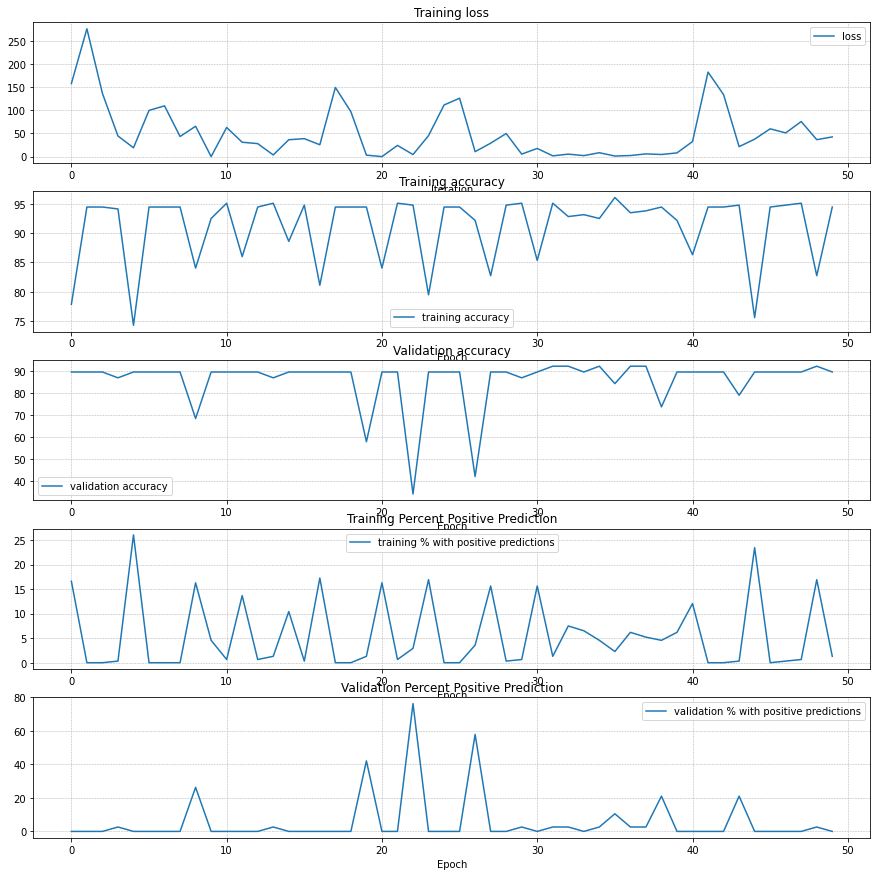

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized

In [182]:
input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=50)

Epoch 0, loss = 8.7846, train_acc = 9.4463, val_acc = 28.9474, train_pos = 96.0912, val_pos = 76.3158
Epoch 1, loss = 1.9035, train_acc = 38.1107, val_acc = 60.5263, train_pos = 65.4723, val_pos = 44.7368
Epoch 2, loss = 1.4328, train_acc = 69.3811, val_acc = 76.3158, train_pos = 29.6417, val_pos = 13.1579
Epoch 3, loss = 0.2566, train_acc = 87.2964, val_acc = 81.5789, train_pos = 8.4691, val_pos = 7.8947
Epoch 4, loss = 0.6245, train_acc = 90.8795, val_acc = 89.4737, train_pos = 3.5831, val_pos = 0.0000
Epoch 5, loss = 0.3446, train_acc = 92.5081, val_acc = 89.4737, train_pos = 1.9544, val_pos = 0.0000
Epoch 6, loss = 0.2120, train_acc = 92.8339, val_acc = 89.4737, train_pos = 1.6287, val_pos = 0.0000
Epoch 7, loss = 0.5108, train_acc = 92.8339, val_acc = 89.4737, train_pos = 1.6287, val_pos = 0.0000
Epoch 8, loss = 0.8924, train_acc = 92.8339, val_acc = 89.4737, train_pos = 1.6287, val_pos = 0.0000
Epoch 9, loss = 0.5874, train_acc = 92.8339, val_acc = 89.4737, train_pos = 1.6287, va

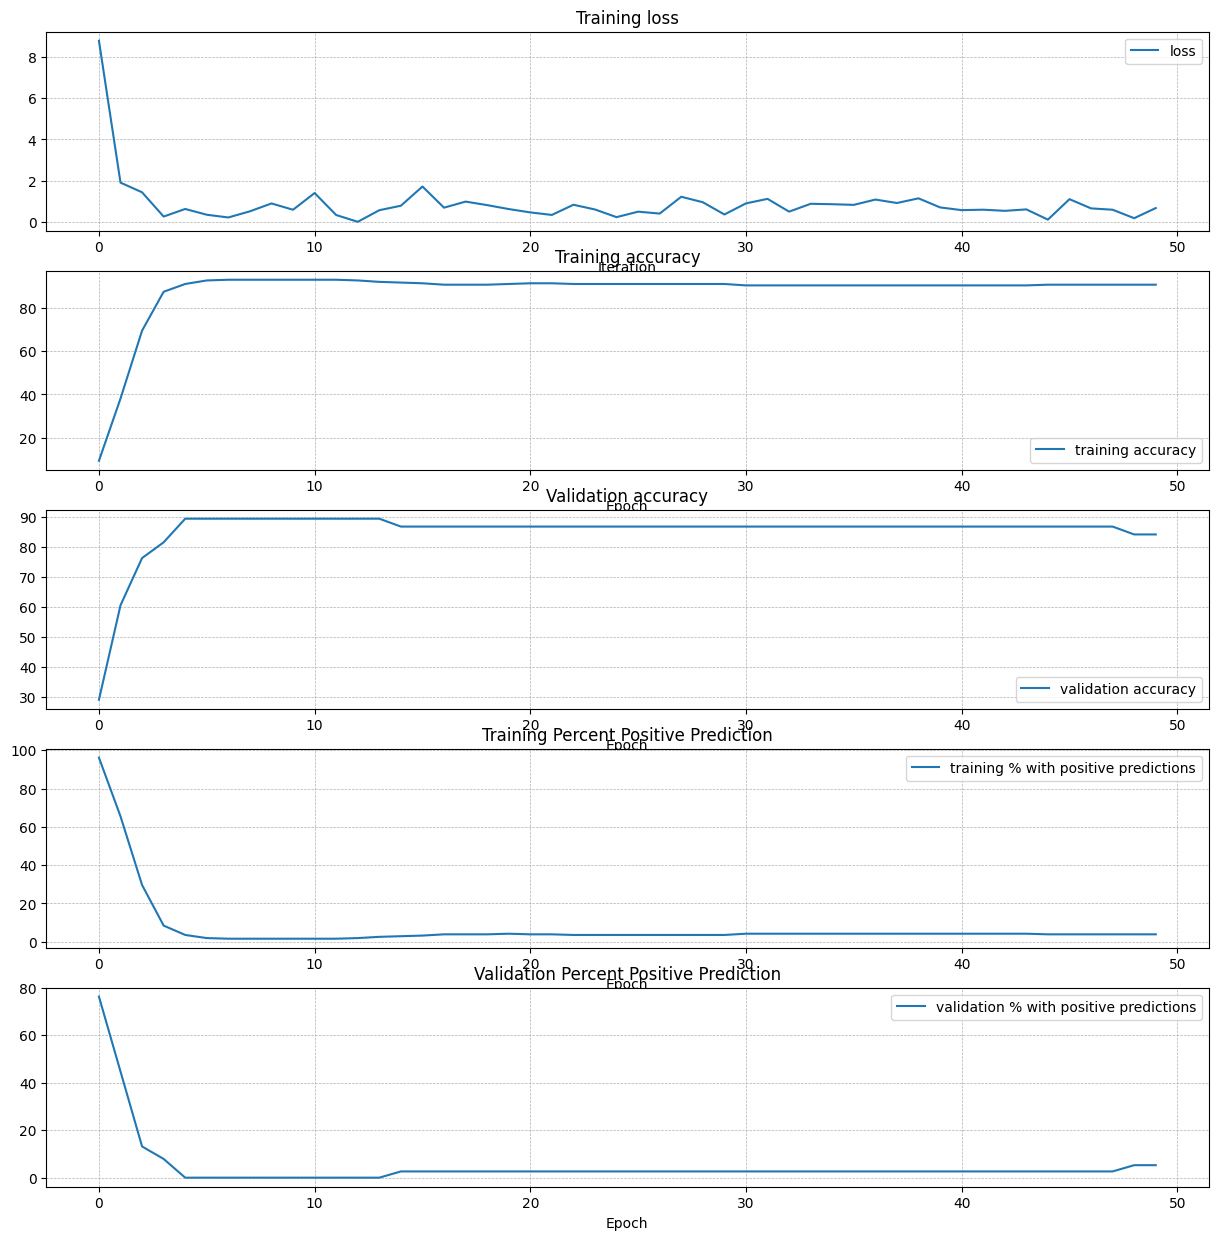

In [183]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

In [72]:
# Placeholder for model visualization